In [1]:
!pip show imbalanced-learn
import sys
sys.version

Name: imbalanced-learn
Version: 0.11.0
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: c:\anaconda\lib\site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 


'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'

In [2]:
!pip install imbalanced-learn


In [11]:

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [5]:
#val - number of days
def antecedent_rainfall(dr,val):
    for i in range(1,val+1):
        s = "antecedent_"+ str(i) + "days"
        x = i + 1
        dr[s] = np.around(abs(dr.depth.rolling(x).sum() - dr.depth),decimals=7)
        
    return dr
#15days antecedent rainfall
#antecedent_rainfall(dr,180)

In [6]:
#Preprocessing rainfall data (dr)
def preprocessing_of_rainfall_data(data, frequency_of_data):
    data = data.replace(-9999.9, np.nan)
    data.columns = ['time','intensity']
    
    data = data.fillna(0)
    data['depth'] = data['intensity'] * frequency_of_data
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data = data.drop(['intensity'],axis=1)
    
    return data

In [7]:
#Preprocessing rainfall data (dr)
def preprocessing_of_rainfall_data(data, frequency_of_data):
    data = data.replace(-9999.9, np.nan)
    data.columns = ['time','intensity']
    
    data = data.fillna(0)
    data['depth'] = data['intensity'] * frequency_of_data
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data = data.drop(['intensity'],axis=1)
    
    return data

In [8]:
#Preprocessing landslide data (dl)
def preprocessing_of_landslide_data(data):
    data.columns = ['time','landslide']
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    landslide_years = data.index.year.unique()
    
    return data, landslide_years



In [12]:
#Merging both data  (df)
def merging_both_data(rainfall_data, landslide_data): 
    data = rainfall_data.join(landslide_data)
    
    data = data.fillna(0)
    data = data.drop(columns=['year','month','day'])
    
    
    return data


In [13]:
dr = preprocessing_of_rainfall_data(pd.read_csv('E:/78.9811,30.2587,79.5660,30.5506/RainfallData/TRMM/2003-2019/DailyTRMM.csv'), 24)
dl, landslide_years = preprocessing_of_landslide_data(pd.read_csv('E:/78.9811,30.2587,79.5660,30.5506/LandslideData/Landslide - Sheet2.csv'))

In [14]:
df = merging_both_data(dr,dl)

In [15]:
df = antecedent_rainfall(df,30)

In [16]:
df = df.dropna(axis=0)

In [17]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['landslide'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['landslide'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 98.85 % of the dataset
Frauds 1.15 % of the dataset


Text(0.5, 1.0, 'Landslide Distributions \n (0: No Landslide || 1: Landslide)')

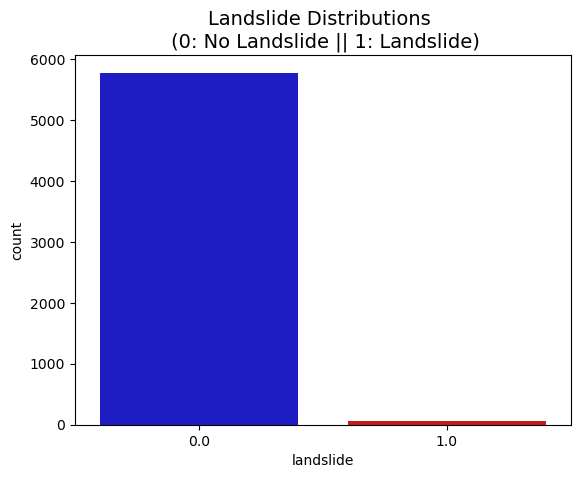

In [18]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('landslide', data=df, palette=colors)
plt.title('Landslide Distributions \n (0: No Landslide || 1: Landslide)', fontsize=14)

In [19]:
df.head()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
time,,,,,,,,,,,,,,,,,,,,,
2003-03-31,0.00,0.0,1.44,5.04,5.04,5.04,5.04,354.239981,464.399985,473.759984,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984
2003-04-01,0.00,0.0,0.00,1.44,5.04,5.04,5.04,5.040000,354.239981,464.399985,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984
2003-04-02,0.00,0.0,0.00,0.00,1.44,5.04,5.04,5.040000,5.040000,354.239981,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984
2003-04-03,0.00,0.0,0.00,0.00,0.00,1.44,5.04,5.040000,5.040000,5.040000,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984
2003-04-04,5.76,0.0,0.00,0.00,0.00,0.00,1.44,5.040000,5.040000,5.040000,...,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984,473.759984


In [20]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()


for i in df.columns:
    if i != 'landslide':
        df[i] = rob_scaler.fit_transform(df[i].values.reshape(-1,1))

In [21]:
df.head()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
time,,,,,,,,,,,,,,,,,,,,,
2003-03-31,0.0,0.0,0.025,0.021277,-0.006656,-0.040975,-0.072169,0.229620,0.235712,0.159465,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-01,0.0,0.0,0.000,0.006079,-0.006656,-0.040975,-0.072169,-0.099864,0.148706,0.153259,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-02,0.0,0.0,0.000,0.000000,-0.014975,-0.040975,-0.072169,-0.099864,-0.127097,0.080210,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-03,0.0,0.0,0.000,0.000000,-0.018303,-0.046512,-0.072169,-0.099864,-0.127097,-0.151349,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-04,0.1,0.0,0.000,0.000000,-0.018303,-0.048726,-0.076317,-0.099864,-0.127097,-0.151349,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.22773,-0.234397,-0.240211,-0.255957,-0.262189


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Landslide', round(df['landslide'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Landslide', round(df['landslide'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('landslide', axis=1)
y = df['landslide']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Landslide 98.85 % of the dataset
Landslide 1.15 % of the dataset
Train: [4106 2055 2593 ... 3119 3695 5074] Test: [1809  470 2495 ...  814 1962 1139]
Train: [2795 2449 5347 ... 4830 3033 5727] Test: [2528 5458 2381 ...  488  968 2065]
Train: [ 334 2632 3907 ... 2478 1989 3928] Test: [3464 1875 2435 ... 1280 5221  432]
Train: [1352 1476 2457 ... 3163 1928 5803] Test: [2888 2788 2206 ... 3330 2058 5745]
Train: [5186  147 4749 ... 1169 1072 2190] Test: [ 279 4830 4951 ...  433  102 1676]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.98844178 0.01155822]
[0.98887938 0.01112062]


In [23]:
df.describe()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,...,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,2.267678,0.011471,2.267682,1.102827,0.887038,0.754585,0.674135,0.634534,0.590800,0.537987,...,0.430867,0.423053,0.416466,0.409844,0.398031,0.386365,0.384384,0.380091,0.387040,0.385461
std,6.319794,0.106494,6.319793,2.515516,1.847539,1.516611,1.339474,1.256701,1.184168,1.104429,...,0.983112,0.968853,0.956996,0.944745,0.922014,0.922087,0.917778,0.909304,0.932223,0.929117
min,0.000000,0.000000,0.000000,0.000000,-0.018303,-0.048726,-0.077976,-0.104620,-0.131078,-0.154691,...,-0.303355,-0.306132,-0.309124,-0.311645,-0.310970,-0.327329,-0.330462,-0.332561,-0.347914,-0.351300
25%,0.000000,0.000000,0.000000,0.000000,-0.018303,-0.048726,-0.077976,-0.104620,-0.131078,-0.154691,...,-0.255061,-0.255049,-0.254240,-0.251140,-0.247400,-0.261031,-0.258048,-0.260140,-0.267626,-0.270043
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.981697,0.951274,0.922024,0.895380,0.868922,0.845309,...,0.744939,0.744951,0.745760,0.748860,0.752600,0.738969,0.741952,0.739860,0.732374,0.729957
max,105.393742,1.000000,105.393742,29.563831,22.330282,15.767442,14.522605,12.430368,10.870628,10.033660,...,7.444188,7.288952,7.100809,7.183755,6.981547,7.230682,7.344186,7.244070,7.228496,7.085726


In [24]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
landslide_df = df.loc[df['landslide'] == 1]
non_landslide_df = df.loc[df['landslide'] == 0][:67]

normal_distributed_df = pd.concat([landslide_df, non_landslide_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
time,,,,,,,,,,,,,,,,,,,,,
2007-08-17,0.8750,0.0,2.462500,0.989362,2.442596,2.372093,2.192451,2.101223,1.897640,1.720936,...,1.495662,1.470895,1.595894,1.686697,1.840331,1.800802,1.756552,1.691018,1.671232,1.616671
2013-07-10,1.8250,1.0,0.306250,0.993921,0.525790,0.313400,0.979262,0.943614,0.746375,0.674863,...,1.066320,1.070547,1.344264,1.808951,2.137931,2.137365,2.180013,2.248491,2.539445,2.857597
2003-12-14,0.0000,0.0,0.137500,0.033435,0.000000,-0.036545,-0.068851,-0.097147,-0.124822,-0.149439,...,-0.301234,-0.304121,-0.307211,-0.309822,-0.309250,-0.325664,-0.328856,-0.331018,-0.346377,-0.348050
2010-09-22,3.0750,1.0,1.075000,0.261398,1.694675,4.589701,3.715471,3.117188,2.652545,2.325376,...,1.825140,1.781139,1.706532,1.647824,1.540152,1.484901,1.417476,1.372561,1.485920,1.425785
2012-09-14,6.8125,1.0,35.037497,10.123100,5.717970,3.799557,2.804645,2.273098,1.962468,1.637384,...,1.526123,1.457187,1.420979,1.461832,1.405114,1.391660,1.866268,1.828632,1.856055,1.823470


Distribution of the Classes in the subsample dataset
0.0    0.5
1.0    0.5
Name: landslide, dtype: float64


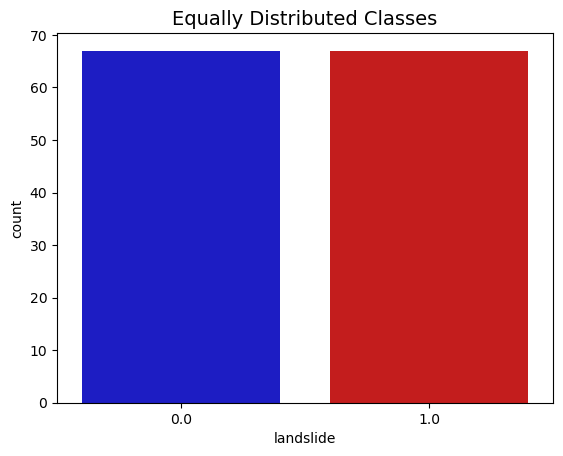

In [25]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['landslide'].value_counts()/len(new_df))



sns.countplot('landslide', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

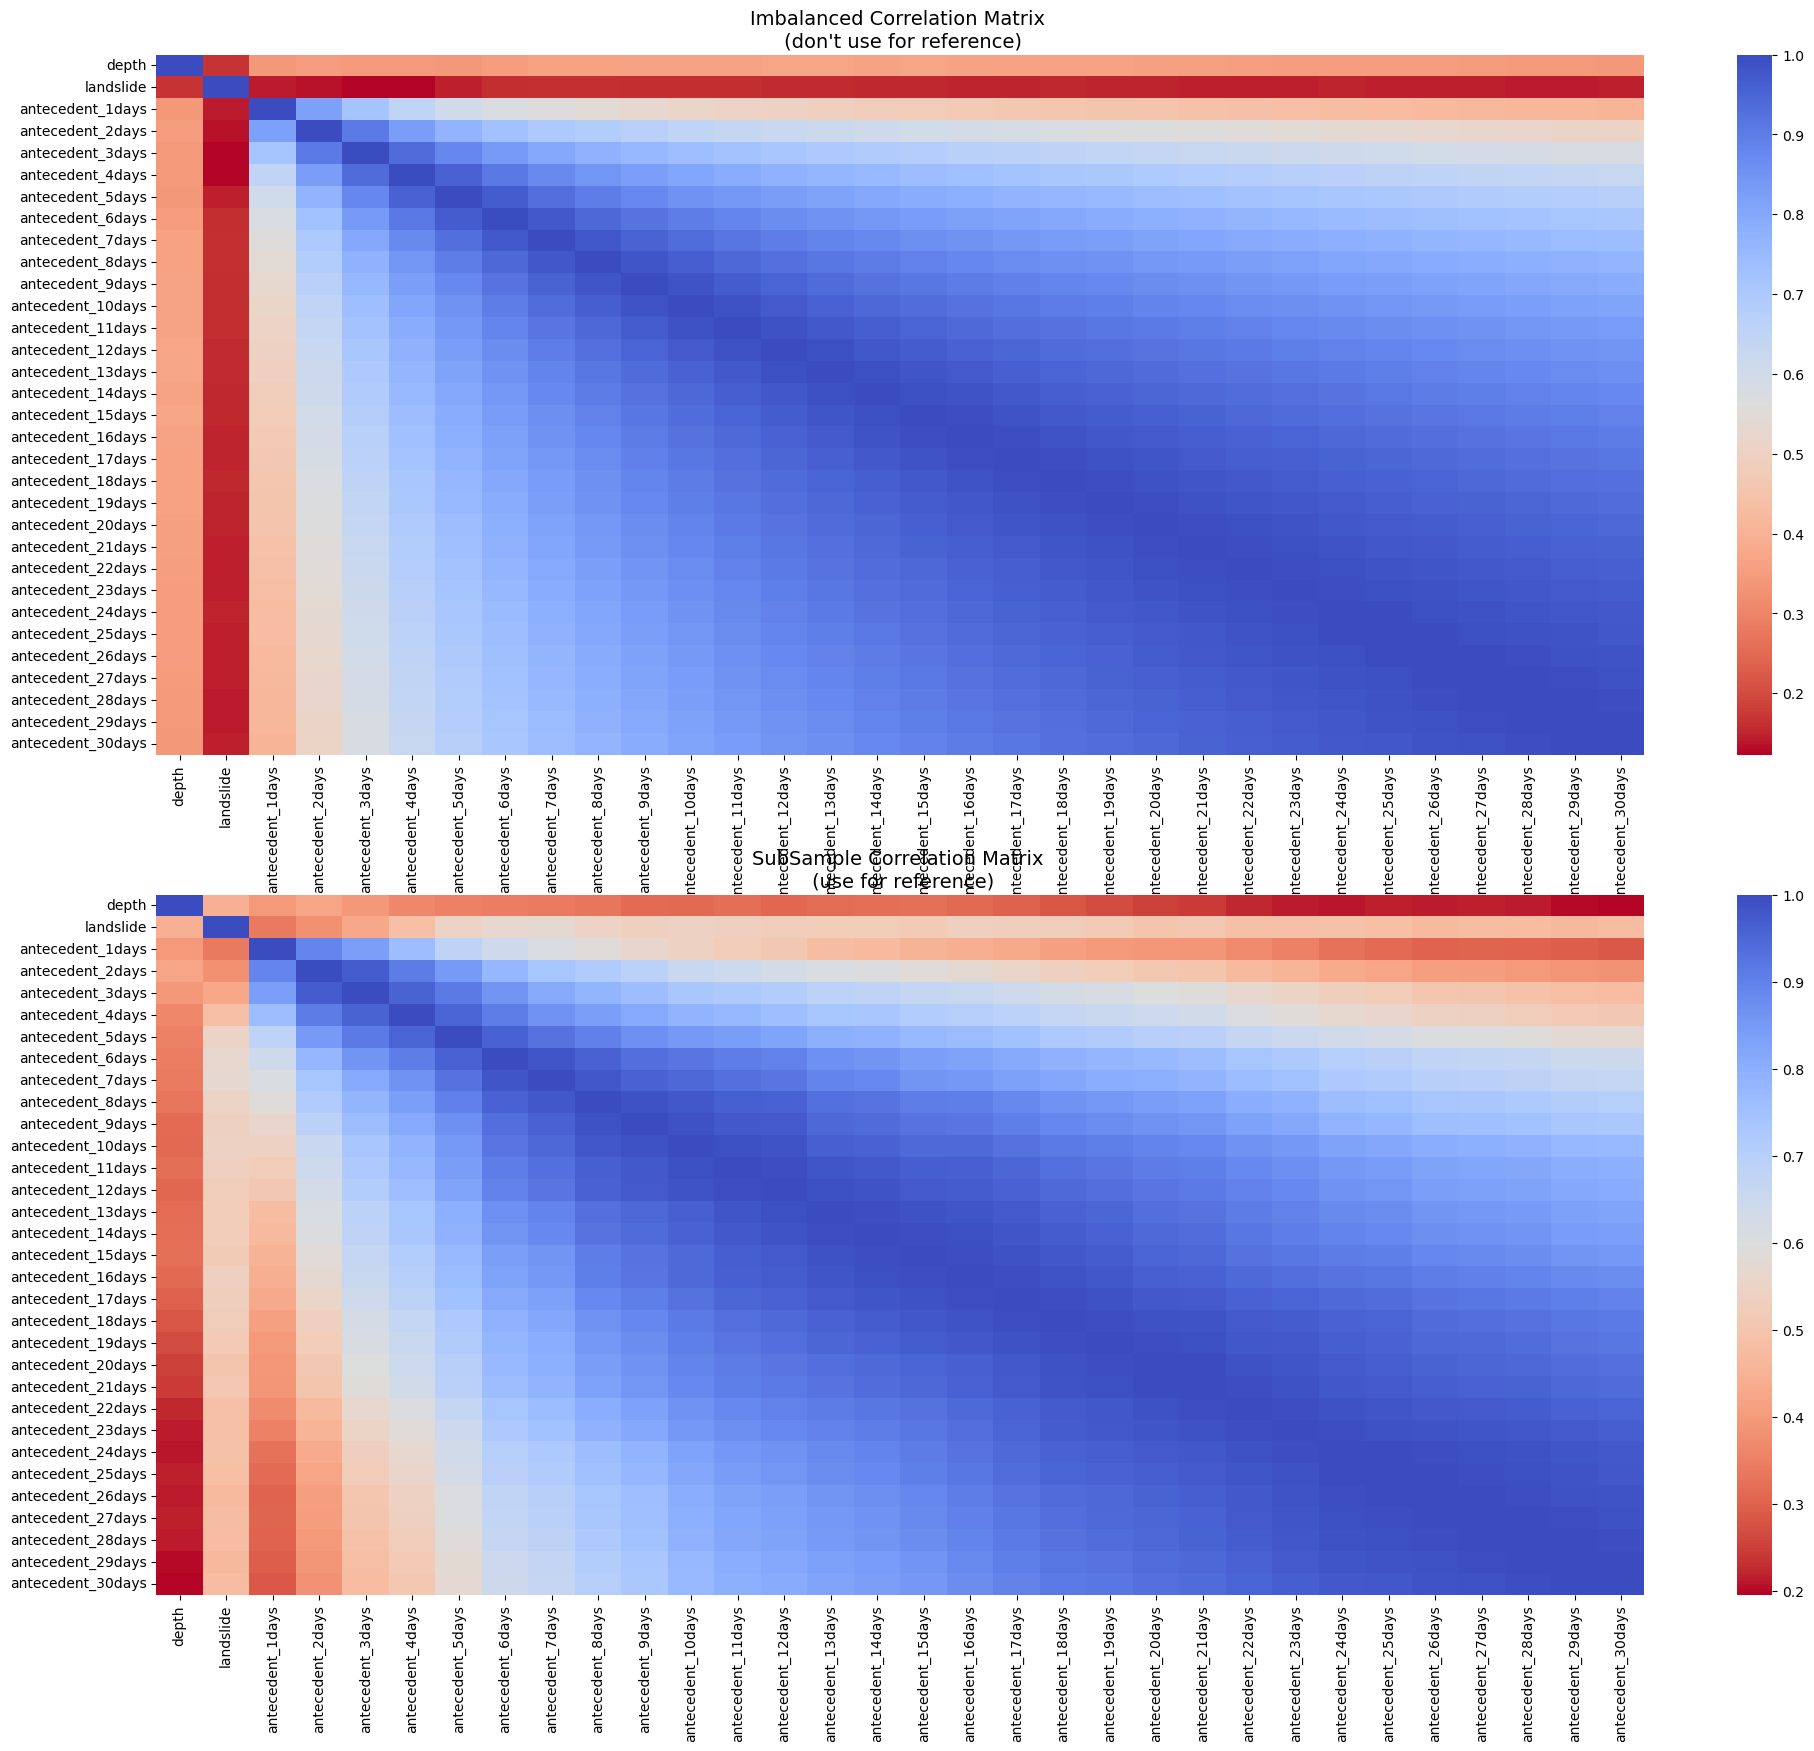

In [26]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()